# CGM Analysis Functions

In [1]:
!pip install pandas;
!pip install matplotlib;
!pip install sklearn;
!pip install scikit-fda;
!pip install fathon;
!pip install numpy;
!pip install scipy;
!pip install openpyxl;
!pip install EntropyHub

#openpyxl appears to be the only library not in requirements.txt at the moment

  Using cached emd-0.5.5-py2.py3-none-any.whl (83 kB)
  Using cached numpy-1.21.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.9 MB)
  Using cached sparse-0.13.0-py2.py3-none-any.whl (77 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from sklearn import preprocessing
import skfda
import numpy as np
from scipy.interpolate import CubicSpline
import openpyxl
import EntropyHub as eh


import matlab.engine
eng = matlab.engine.connect_matlab()


import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_excel('../data/glucose_sample.xlsx')
display(data.loc[:,['GlucoseDisplayTime','Value']])
test = data.copy()
test.sort_values('GlucoseDisplayTime', ascending=True, inplace=True)

conv_date = data.GlucoseDisplayTime.dt.time
data['GlucosdeDisplayDay'] = data.GlucoseDisplayTime.dt.date

timeOfday = pd.Series()
day = pd.Series()
datedisplay = pd.Series()
for i in range(len(conv_date)):
    timeOfday.at[i] = conv_date[i].hour + conv_date[i].minute/60 + conv_date[i].second/3600
    datedisplay.at[i] = data.GlucoseDisplayTime[i].date()
    
#timeOfday = cgm_functions.date2float(data.GlucoseDisplayTime.dt.time)
data['GlucoseDisplayTimeNoDay'] = timeOfday
data['GlucoseDisplayDate'] = datedisplay

,GlucoseDisplayTime,Value
0,2022-09-13 19:15:45,111
1,2022-09-13 19:20:45,109
2,2022-09-13 19:25:45,111
3,2022-09-13 19:30:45,111
4,2022-09-13 19:35:45,110
...,...,...
1715,2022-09-15 19:31:01,0
1716,2022-09-15 19:34:26,254
1717,2022-09-15 19:39:26,251
1718,2022-09-15 19:44:26,245


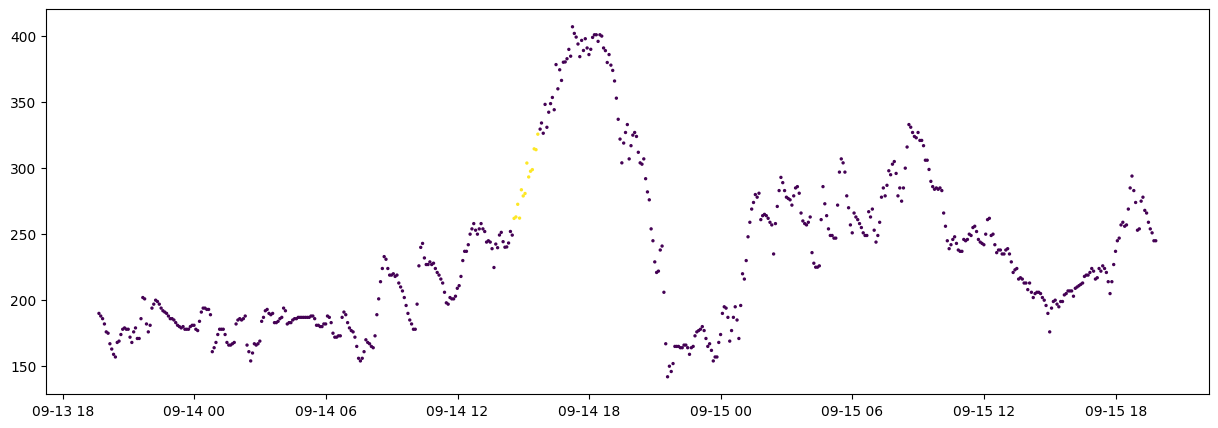

In [11]:
plt.rcParams["figure.figsize"] = (15,5)
patIDs = data.PatientId.unique().tolist()

test = data.loc[data.PatientId == patIDs[1]]

output = fillUnrecorded(test)

no_zero = ZeroToNaN(output)

interp = interpolateMissing(no_zero)

subset = interp.loc[interp['PatientId'] == patIDs[1]]

plt.scatter(subset.GlucoseDisplayTime, subset.Value, c=subset.inserted, s=2)
#plt.axvline(no_zero.loc[no_zero.inserted == 1].GlucoseDisplayTime)

In [ ]:
subset = data.loc[data['PatientId'] == patIDs[1]]
plt.scatter(subset.GlucoseDisplayTime, subset.Value, s=2)

### Convert Zero Values to NaN

In [6]:
def ZeroToNaN(df):
    # Description: Replace the zero values in the data with missing (NaN) values for interpolation methods
    #     INPUTS
    #        df: dataframe of raw data that has incorrectly labeled zero values for CGM values
    #     OUTPUTS
    #        df_missing: dataframe with zeros converted to NaNs
    
    df['missing'] = pd.Series(0, df.index)
    df.Value.replace(0, np.nan, inplace=True)

    missing_label = df[df.Value.isnull()].index
    df['missing'].iloc[missing_label] = 1
    
    df_missing = df.copy()
     
    return df_missing

### Find Unrecorded 5-minute Sample

In [7]:
def fillUnrecorded(df):
    # Description: Find gaps in sampling and insert samples that fill the time-gap with a missing value
    #     INPUTS: 
    #         df: dataframe of the raw data that hasn't replaced zeros with NaNs
    #     OUTPUTS:
    #         df_filled: dataframe with inserted timestamps
    
    fill_df = df.copy()
    fill_df['inserted'] = 0;
    stitched_df = pd.DataFrame(columns = fill_df.columns)
    
    patIDs = fill_df.PatientId.unique().tolist()

    for pat in range(len(patIDs)):
        subset = fill_df.loc[fill_df.PatientId == patIDs[pat]]  
        subset.sort_values("GlucoseDisplayTime", ascending=True, inplace=True)
        subset.reset_index(drop=True, inplace=True)
        display_times = subset.GlucoseDisplayTime

        
        for i in range(1, len(display_times)-1):
            current = display_times[i]
            previous = display_times[i-1]
            delta = current - previous
            delta_sec = delta.seconds
            
            steps_missing = np.int(np.round(delta_sec / 300)-1) # how many 5-minute samples are missing
            
            if steps_missing > 0:
                for step in range(steps_missing):
                    row_number = i + (step-1)
                    row_data = subset.iloc[i-1]
                    time_feats = ['RecordedSystemTime', 'RecordedDisplayTime', 'GlucoseSystemTime', 'GlucoseDisplayTime']
                    row_data[time_feats] = row_data[time_feats] + np.timedelta64(5*(step+1), 'm')
                    row_data['inserted'] = 1
                    subset_fill = insertRow(row_number, subset, row_data)
            else:
                subset_fill = subset
                        
        stitched_df = pd.concat([stitched_df, subset_fill])
        
    stitched_df.sort_values("GlucoseDisplayTime", ascending=True, inplace=True)
    stitched_df.reset_index(drop=True, inplace=True)
                
    return stitched_df

### Insert Row into Dataframe

In [8]:
def insertRow(row_number, df, row_value):
    # Starting value of upper half
    start_upper = 0
  
    # End value of upper half
    end_upper = row_number
  
    # Start value of lower half
    start_lower = row_number
  
    # End value of lower half
    end_lower = df.shape[0]
  
    # Create a list of upper_half index
    upper_half = [*range(start_upper, end_upper, 1)]
  
    # Create a list of lower_half index
    lower_half = [*range(start_lower, end_lower, 1)]
  
    # Increment the value of lower half by 1
    lower_half = [x.__add__(1) for x in lower_half]
  
    # Combine the two lists
    index_ = upper_half + lower_half
  
    # Update the index of the dataframe
    df.index = index_
  
    # Insert a row at the end
    df.loc[row_number] = row_value
   
    # Sort the index labels
    df = df.sort_index()
  
    # return the dataframe
    return df

### Interpolate Missing Data

In [9]:
def interpolateMissing(df):
    data = df.copy()
    data['missing'] = pd.Series(0, data.index)
    data.Value.replace(0, np.nan, inplace=True)
    missing_label = data[data.Value.isnull()].index
    data['missing'].iloc[missing_label] = 1

    interp_df = pd.DataFrame(columns=data.columns);
    patIDs = data.PatientId.unique().tolist()
    
    for pat in range(len(patIDs)):
        subset = data.loc[data.PatientId == patIDs[pat]]  
        subset.sort_values("GlucoseDisplayTime", ascending=True, inplace=True)
        subset.reset_index(drop=True, inplace=True)
        subset.Value.interpolate(method='pchip', inplace=True)
        
        missing_vals = subset.loc[subset.missing == 1]
        sigma = np.sqrt(np.std(subset.Value))
        
        for i in missing_vals.index:
                jiggle = sigma*np.random.randn()
                subset.at[i, 'Value'] = subset.at[i, 'Value'] + jiggle
        
        interp_df = pd.concat([interp_df, subset])
        
    interp_df.dropna(axis=0, subset="Value", inplace=True)
    
    return interp_df

### Daily Median Glucose Value

In [10]:
def compressDailyValues(data):
    fs = 1/300
    lower = 70
    upper = 180
    
    median_df = pd.DataFrame(columns=['PatientId', 'Median', 'Mean', 'STD', 'Max', 'Min', 'AreaBelow', 'AreaAbove', 'Date'])
    patIDs = data.PatientId.unique()
    
    for pat in patIDs:
        pat_sub = data.loc[data.PatientId == pat]
        dates = pat_sub.GlucoseDisplayDate.unique()
        
        for date in dates:
            date_sub = pat_sub.loc[pat_sub.GlucoseDisplayDate == date]
            
            # obtain summary values
            median = np.nanmedian(date_sub.Value)
            mean = np.nanmean(date_sub.Value)
            std = np.nanstd(date_sub.Value)
            maxVal = np.nanmax(date_sub.Value)
            minVal = np.nanmin(date_sub.Value)
            
            # obtain areas above and below recommendation
            upperSegs = date_sub.loc[date_sub.Value > upper].Value - upper
            areaAbove = np.nansum(upperSegs)
            lowerSegs = -(date_sub.loc[date_sub.Value < lower].Value - lower)
            areaBelow = np.nansum(lowerSegs)
            
            # EMD  
            #imf = emd.sift.sift(date_sub.Value)
            #display(imf)
            
            # CWT
            [wt, f, coi] = eng.cwt(date_sub.Value, fs, nargout=3)
            wt = eng.abs(wt)

            lowpass = eng.lowpass(mat_dat, 1/3000, fs)
            [wcoh1,wcs1,f1] = eng.wcoherence(mat_dat,lowpass,fs, nargout=3)
            
            
            sample = [pat, median, mean, std, maxVal, minVal, areaBelow, areaAbove, date]
            
            median_df.loc[len(median_df.index)] = sample
                                   
    return median_df

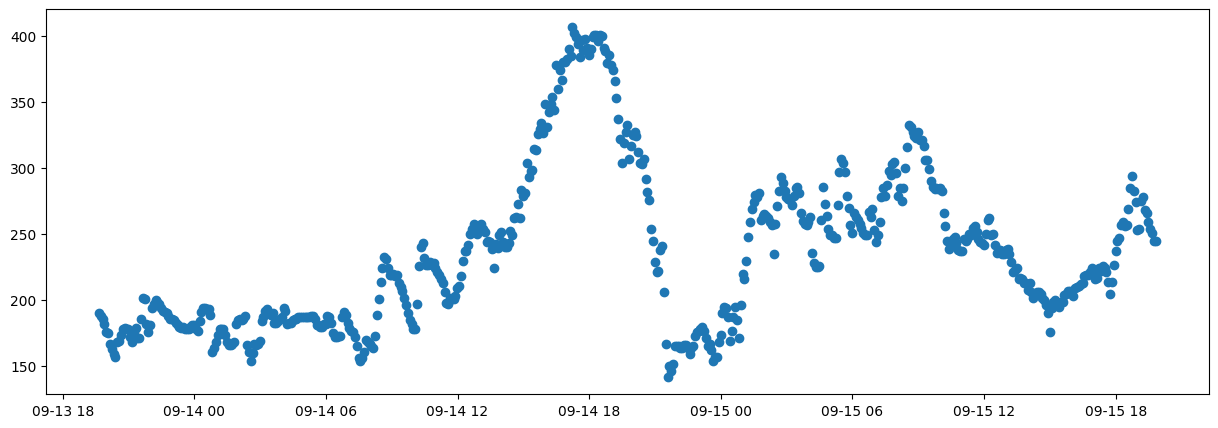

In [12]:
plt.scatter(interp.loc[interp.PatientId == patIDs[1]].GlucoseDisplayTime, interp.loc[interp.PatientId == patIDs[1]].Value)

In [14]:
#import emd
#help(emd.plotting.plot_hilberthuang)

ContextualVersionConflict: (numpy 1.23.5 (/opt/conda/lib/python3.10/site-packages), Requirement.parse('numpy<1.22'), {'emd'})

In [15]:
subset = interp.loc[data.PatientId == patIDs[0]]
dates = subset.GlucoseDisplayDate.unique()
datasubset = subset.loc[subset.GlucoseDisplayDate == dates[2]]
imf = emd.sift.sift(datasubset.Value)
fs = 1/300
IP, IF, IA = emd.spectra.frequency_transform(imf, fs, 'hilbert')
freq_range = (0.000012, .00167, 50, 'log')
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)
#emd.plotting.plot_imfs(imf)

fig = plt.figure(figsize=(10, 6))

#print(len(f))
emd.plotting.plot_hilberthuang(hht, np.linspace(0,len(datasubset.Value)), f, fig=fig, log_y=True, cmap='viridis')
plt.clim()

NameError: name 'emd' is not defined

In [ ]:
vars(emd.plotting.plot_hilberthuang)

In [ ]:
test = compressDailyValues(data)
test